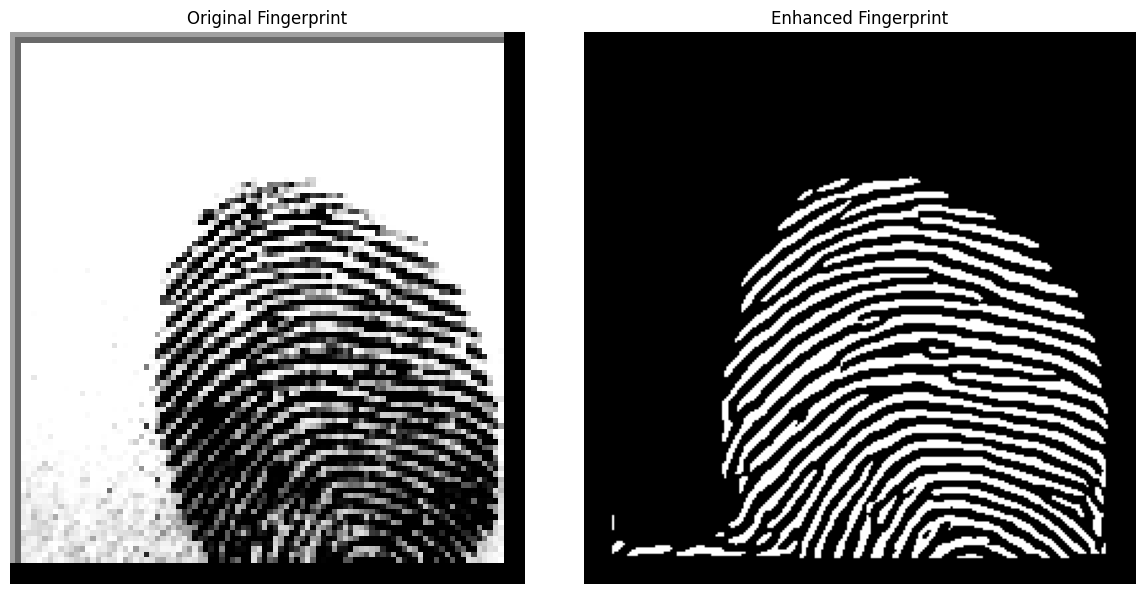

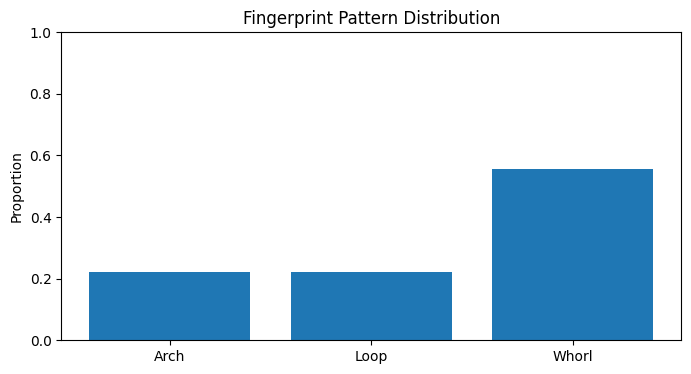


🧬 Predicted Blood Group: AB+ (Confidence: 98.22%)

📊 Pattern Distribution:
Arch: 22.2%
Loop: 22.2%
Whorl: 55.6%

🔍 Confidence scores for all classes:
A+  : 0.37%
A-  : 0.12%
AB+ : 98.22%
AB- : 0.14%
B+  : 0.31%
B-  : 0.19%
O+  : 0.14%
O-  : 0.52%


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import fingerprint_enhancer
from tqdm import tqdm

# Configuration
IMG_EXTS = (".bmp", ".BMP", ".jpg", ".jpeg", ".png")
MODEL_PATHS = {
    'efficientnet': "efficientnet.h5",
    'mobilenet': "mobilenet_model_pattern.h5",
    'densenet': "densenet_model.h5"
}
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
PATCH_SIZE = 64  # Size for fingerprint pattern analysis

# Image Enhancement Parameters
denoise_h = 10
denoise_hColor = 10
templateWindowSize = 7
searchWindowSize = 21
alpha = 1.2   # contrast
beta = 20     # brightness
sharpen_kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
TARGET_SIZE = (256, 256)

# Pattern Analysis Functions
def compute_orientation(block):
    """Calculate dominant orientation using gradient information"""
    gx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    return 0.5 * np.arctan2(2 * np.sum(gx * gy), np.sum(gx**2 - gy**2))

def classify_pattern_distribution(angle_deg):
    """Classify pattern based on orientation angle"""
    angle_deg = angle_deg % 180
    if 75 < angle_deg < 105: return 'Arch'
    if 30 < angle_deg <= 75: return 'Loop'
    if angle_deg <= 30 or angle_deg >= 150: return 'Whorl'
    return 'Other'

def get_pattern_distribution(img):
    """Calculate pattern distribution for a single image"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    counts = {'Arch': 0, 'Loop': 0, 'Whorl': 0, 'Other': 0}

    for y in range(0, 256 - PATCH_SIZE, PATCH_SIZE):
        for x in range(0, 256 - PATCH_SIZE, PATCH_SIZE):
            block = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            angle = compute_orientation(block)
            pattern = classify_pattern_distribution(np.degrees(angle))
            counts[pattern] += 1

    total = sum(counts.values())
    return [counts['Arch']/total, counts['Loop']/total, counts['Whorl']/total]

def enhance_image(img):
    """Enhance fingerprint image through multiple steps"""
    # 1) Denoise color
    denoised = cv2.fastNlMeansDenoisingColored(img, None, denoise_h, denoise_hColor,
                                              templateWindowSize, searchWindowSize)
    # 2) Sharpen
    sharpened = cv2.filter2D(denoised, -1, sharpen_kernel)

    # 3) Brightness & Contrast
    adjusted = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

    # 4) Resize
    resized = cv2.resize(adjusted, TARGET_SIZE, interpolation=cv2.INTER_AREA)

    # 5) Convert to grayscale for fingerprint enhancement
    gray_img = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.equalizeHist(gray_img)

    # 6) Fingerprint enhancement
    enhanced_fp = fingerprint_enhancer.enhance_fingerprint(gray_img)
    enhanced_uint8 = (enhanced_fp * 255).astype(np.uint8)

    return enhanced_uint8

def load_ensemble_models():
    """Load all models for ensemble prediction"""
    models = {}
    for name, path in MODEL_PATHS.items():
        if name == 'efficientnet':
            # Assuming EfficientNet is a custom model with similar interface
            model = build_efficientnet()
            model.load_weights('efficientnet.h5')
        else:
            model = load_model(path)
        models[name] = model
    return models

def ensemble_predict(models, image_input, pattern_input, weights=[0.33, 0.33, 0.34]):
    """Make prediction using ensemble of models"""
    preds = []
    for name, model in models.items():
        pred = model.predict([image_input, pattern_input], verbose=0)
        preds.append(pred)

    # Weighted ensemble prediction
    ensemble_pred = (
        weights[0] * preds[0] +
        weights[1] * preds[1] +
        weights[2] * preds[2]
    )
    return ensemble_pred

def analyze_fingerprint(image_path):
    """Complete analysis pipeline for a single fingerprint image"""
    # 1. Load and validate image
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise FileNotFoundError(f"Cannot load input image: {image_path}")

    # 2. Enhance image
    enhanced_img = enhance_image(original_img)

    # 3. Calculate pattern distribution
    pattern_dist = get_pattern_distribution(enhanced_img)
    pattern_input = np.array([pattern_dist])

    # 4. Prepare image input for model
    normalized = enhanced_img.astype('float32') / 255.0
    rgb_input = np.stack((normalized,) * 3, axis=-1)
    image_input = np.expand_dims(rgb_input, axis=0)

    # 5. Load models and make prediction
    models = load_ensemble_models()
    ensemble_pred = ensemble_predict(models, image_input, pattern_input)

    # 6. Process results
    confidence_scores = ensemble_pred[0]
    predicted_index = np.argmax(confidence_scores)
    predicted_class = class_names[predicted_index]

    # 7. Display results
    plt.figure(figsize=(12, 6))

    # Original and enhanced images
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Fingerprint")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_img, cmap='gray')
    plt.title("Enhanced Fingerprint")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Pattern distribution
    patterns = ['Arch', 'Loop', 'Whorl']
    plt.figure(figsize=(8, 4))
    plt.bar(patterns, pattern_dist)
    plt.title("Fingerprint Pattern Distribution")
    plt.ylabel("Proportion")
    plt.ylim(0, 1)
    plt.show()

    # Prediction results
    print(f"\n🧬 Predicted Blood Group: {predicted_class} (Confidence: {confidence_scores[predicted_index]*100:.2f}%)")
    print("\n📊 Pattern Distribution:")
    for pat, val in zip(patterns, pattern_dist):
        print(f"{pat}: {val*100:.1f}%")

    print("\n🔍 Confidence scores for all classes:")
    for idx, score in enumerate(confidence_scores):
        print(f"{class_names[idx]:<4}: {score * 100:.2f}%")

    return {
        'enhanced_image': enhanced_img,
        'pattern_distribution': dict(zip(patterns, pattern_dist)),
        'predicted_class': predicted_class,
        'confidence': confidence_scores[predicted_index],
        'all_scores': confidence_scores
    }

# Main execution
if __name__ == "__main__":
    # Example usage
    img_path = r"C:\Users\mdtan\OneDrive\Desktop\New folder (4)\AB+\cluster_4_51.BMP"
    results = analyze_fingerprint(img_path)